# Common Raster Tasks

In This notebook, we demonstrate some common raster tasks, important in day-to-day work at Vizzuality involving reading, transforming, and writing raster data in NetCDF, a common scientific data format, and Geotiff, a common web-mapping format.

#### Extract data from local and remote NetCDF files

    Read data from the common NetCDF file format using Xray, with intelligent handling of attributes, and perform statistical grouping tasks, similar to Pandas.


#### Minify rasters

    Often we will need to lightweight rasters by 1) re-scaling the data to fit an int8 (0-255) representation, and compressing the data (using zip or lzw compression).


#### Convert NetCDF data to geotiff

    How to extract data from netcdf files (local or remote) and convert it into a geotiff.


#### Extracting data from geotiff directly
    Simple example of extracting multi-band geotiff data, similar to previous examples.
    Including an example of windowing large data.

#### Extract data from Google Earth Engine
    Example of extracting Earth Engine images in geotiff format.


#### Intersect rasters with vector data

(I feel like this should be in a diffrent workbook - one about operations on vectors/rasters and vector/vector )

    Extract vector format data (e.g. projected polygons), overlay them onto an array (raster) extracted from either a tiff or netcdf, and extract statistics from the intersecting area.

In [1]:
from __future__ import print_function
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.image as mpimg
import rasterio
import cartopy
import cartopy.crs as ccrs
from hurry.filesize import size
%matplotlib inline

## Extracting data from a NetCDF File

Using smarter axis manipulation, like pandas, we can use [Xray](http://nbviewer.jupyter.org/github/nicolasfauchereau/metocean/blob/master/notebooks/xray.ipynb) (formerly xarray).

In [2]:
# Connect to a dataset
ncfile = xr.open_dataset("./data/modis_example.nc")

In [3]:
# Introspect the top level of a connected dataset
ncfile

<xarray.Dataset>
Dimensions:                   (lat: 180, lon: 360)
Coordinates:
  * lat                       (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ...
  * lon                       (lon) float32 -179.5 -178.5 -177.5 -176.5 ...
Data variables:
    Cloud_Fraction_Mean_Mean  (lat, lon) float64 0.3214 0.3142 0.3215 0.3183 ...
Attributes:
    Conventions: CF-1.0

In [4]:
# Access metadata layer of a specific variable in a connected dataset
ncfile.Cloud_Fraction_Mean_Mean

<xarray.DataArray 'Cloud_Fraction_Mean_Mean' (lat: 180, lon: 360)>
array([[ 0.321384,  0.314188,  0.321528, ...,  0.31816 ,  0.314324,  0.313344],
       [ 0.329752,  0.335152,  0.33868 , ...,  0.326344,  0.331944,  0.330348],
       [ 0.443748,  0.454672,  0.465576, ...,  0.419704,  0.428532,  0.436016],
       ..., 
       [ 0.793   ,  0.79454 ,  0.79514 , ...,  0.795488,  0.796516,  0.795984],
       [ 0.829696,  0.82914 ,  0.827804, ...,  0.829872,  0.828984,  0.828056],
       [ 0.844236,  0.846888,  0.842844, ...,  0.842616,  0.843956,  0.844476]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Attributes:
    Quality_Assurance_Data_Set: No_QA
    Weighting: Unweighted
    Derived_From_Level_3_Daily_Data_Set: Cloud_Fraction_Mean
    long_name: Cloud Fraction from Cloud Mask (count of lowest 2 clear sky confidence  levels, cloudy & probably cloudy / total co

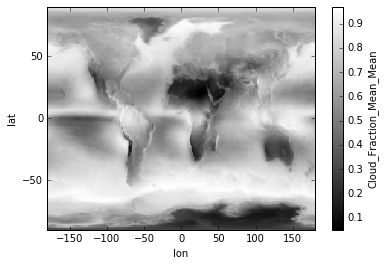

In [5]:
# We can use an equivalent of matplotlib's IMSHOW function to quick view the data array
ncfile.Cloud_Fraction_Mean_Mean[:].plot(cmap=cm.gist_gray)

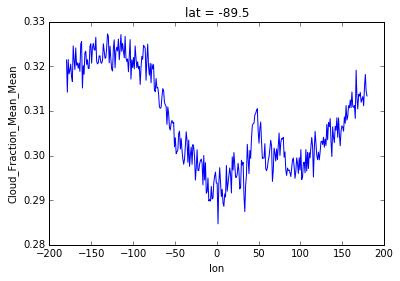

In [6]:
# or plot just a slice across longitude
ncfile.Cloud_Fraction_Mean_Mean[0].plot()

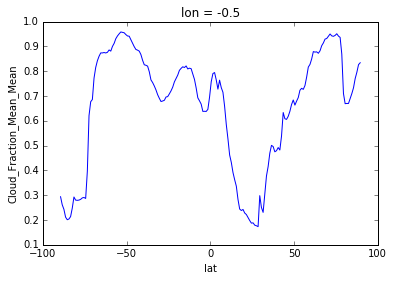

In [7]:
# You can use the attributes to access the array directly
# for example, using every (:) latitude, and the -0.5 longitude as indexes.

ncfile.Cloud_Fraction_Mean_Mean.loc[:,-0.5].plot()

In [8]:
# Elegantly, you can pass a dictionary with the attribute and coordinate specified as an index
pixel = ncfile.Cloud_Fraction_Mean_Mean.loc[{'lat': -0.5, 'lon':-177.5}]
pixel

<xarray.DataArray 'Cloud_Fraction_Mean_Mean' ()>
array(0.5509079694747925)
Coordinates:
    lat      float32 -0.5
    lon      float32 -177.5
Attributes:
    Quality_Assurance_Data_Set: No_QA
    Weighting: Unweighted
    Derived_From_Level_3_Daily_Data_Set: Cloud_Fraction_Mean
    long_name: Cloud Fraction from Cloud Mask (count of lowest 2 clear sky confidence  levels, cloudy & probably cloudy / total count): Mean of Daily Mean
    Statistic_Type: Simple
    units: 1
    Aggregation_Data_Set: None
    valid_range: [    0 10000]
    Included_Level_2_Nighttime_Data: True
    Level_2_Pixel_Values_Read_As: Real
    structureType: Grid
    unitsCategory: fraction

(-90, 90)

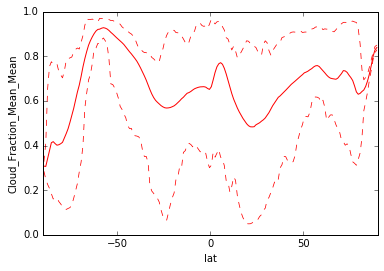

In [9]:
# Grouping by attributes is also easy, for example if we need to group the data by latitude:

lat_mean =ncfile.Cloud_Fraction_Mean_Mean.groupby('lat').mean()
lat_max =ncfile.Cloud_Fraction_Mean_Mean.groupby('lat').max()
lat_min =ncfile.Cloud_Fraction_Mean_Mean.groupby('lat').min()

lat_mean.plot(color='r')
lat_max.plot(color='r',ls='--', lw=0.75)
lat_min.plot(color='r',ls='--', lw=0.75)
plt.xlim(-90,90)

# In this way, it would be possible to manipulate time dimensions to create seasonal data

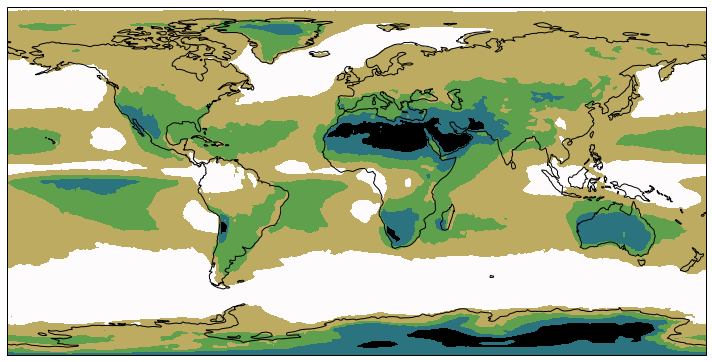

In [10]:
# We can also easily create a more advanced preview plot with boundaries projected using cartopy
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree());
ncfile.Cloud_Fraction_Mean_Mean.plot.contourf(ax=ax, x='lon', y='lat', add_colorbar=False, cmap=cm.gist_earth)
ax.coastlines()
plt.tight_layout()

### Connect to a remote NetCDF file (via OpenDAP)

The [OpenDAP framework](http://www.opendap.org) enables us to connect to remote datasets painlessly.
We should have this out-of-the box with NetCDF libraries.

Many data centers list their OpenDAP exposed data:
* https://disc.sci.gsfc.nasa.gov/disc/services/opendap/
* https://www.esrl.noaa.gov/psd/data/gridded/using_dods.html
* https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/
* https://www.unidata.ucar.edu/software/netcdf/docs/dap_accessing_data.html

[More info on OpenDAP](https://developer.earthdata.nasa.gov/opendap/userguide)

In [11]:
url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/ncdcOisst2Agg'
ncexample = xr.open_dataset(url)

In [12]:
ncexample

<xarray.Dataset>
Dimensions:    (altitude: 1, latitude: 720, longitude: 1440, time: 12992)
Coordinates:
  * time       (time) datetime64[ns] 1981-09-01 1981-09-02 1981-09-03 ...
  * altitude   (altitude) float32 0.0
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 -89.125 -88.875 ...
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
Data variables:
    sst        (time, altitude, latitude, longitude) float64 ...
    anom       (time, altitude, latitude, longitude) float64 ...
    err        (time, altitude, latitude, longitude) float64 ...
    ice        (time, altitude, latitude, longitude) float64 ...
Attributes:
    cdm_data_type: Grid
    Contact: Dick Reynolds, email: Richard.W.Reynolds@noaa.gov & Chunying Liu, email: Chunying.liu@noaa.gov
    contributor_name: NOAA NCDC
    contributor_role: Source of data.
    Conventions: COARDS, CF-1.6, ACDD-1.3
    creation_date: 2017-03-20 11:10
    Easternmost_Easting: 359.875
    geospatial_lat_max: 

In [13]:
sst = ncexample.sst[0,0,:,:]  # call the data locally

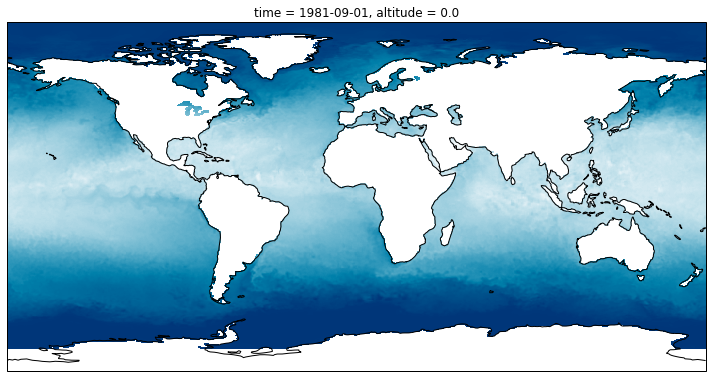

In [14]:
# Graph the data
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0));
sst.plot.pcolormesh(ax=ax, x='longitude', y='latitude',
                                                add_colorbar=False, cmap=cm.ocean)
ax.coastlines()
plt.tight_layout()

In [15]:
ax.properties()

{'adjustable': 'box',
 'agg_filter': None,
 'alpha': None,
 'anchor': 'C',
 'animated': False,
 'aspect': 'equal',
 'autoscale_on': False,
 'autoscalex_on': False,
 'autoscaley_on': False,
 'axes': <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x123cef7b8>,
 'axes_locator': None,
 'axis_bgcolor': 'w',
 'axisbelow': False,
 'children': [<matplotlib.collections.QuadMesh at 0x123d73b70>,
 'clip_box': None,
 'clip_on': True,
 'clip_path': None,
 'contains': None,
 'cursor_props': (1, (0.0, 0.0, 0.0, 1.0)),
 'data_ratio': 0.5,
 'default_bbox_extra_artists': [<matplotlib.collections.QuadMesh at 0x123d73b70>,
 'extent': (-179.99999999999997, 180.0, -90.0, 90.0),
 'figure': <matplotlib.figure.Figure at 0x123cbaf98>,
 'frame_on': True,
 'geometry': (1, 1, 1),
 'gid': None,
 'images': <a list of 0 AxesImage objects>,
 'label': '',
 'legend': None,
 'legend_handles_labels': ([], []),
 'lines': <a list of 0 Line2D objects>,
 'navigate': True,
 'navigate_mode': None,
 'path_effects': [],
 'picker': None,


In [16]:
ax.projection.proj4_params

{'a': 57.29577951308232, 'ellps': 'WGS84', 'lon_0': 0, 'proj': 'eqc'}

### Minify raster data

Looking at the 0.5 degree resolution SST data grabbed from the last section, the actual data values are stored in  float64 format. A single array slice itself is ~7MB.

**Note**: the procedure described here is lossy, therefore the particular project goals should be considered before it is applied.

In [17]:
print("Array slice is {0}".format(size(sst.values.nbytes)))

Array slice is 7M


To reduce the size of these data, we can map the values to 8-bit integers, by binning the current data values to a range of 0-255. We need to document the conversion, to reconstruct the physical values upon display.
0 should also be used to represent missing data (so unsigned integers can be used).

Note, this methodology is lossy, so should not be used for purposes where exact data representation is subsequently needed in the visualisation.

In [18]:
print(f"Valid data range {sst.valid_min} to {sst.valid_max}")

Valid data range -3.0 to 45.0


In [19]:
def convert_array(arr, oldMax, oldMin, missing_value=None, newMin=1, newMax=255, newMissing=0):
    """
    Convert an input value into a new value between 1 to 255.
    Missing data are set to 0 values. After this, the array can be saved
    as int8 format to save space. This function should be vectorised before it
    is applied:
    oldMax and oldMin can be directly set to a physical range which you want to
    be static. For example, if you want a range of -30 to +30 degrees, rather
    than to use values from the array itself.
    e.g. f = np.vectorize()
    Note, to avoid having to import numpy if not needed, it relies on the fact
    that NAN values are not equal to themselves to make the comparison.
    """
    if missing_value:
        mask = arr == missing_value
        arr[mask] = np.nan  # temporarily mask out values that should be missing
    oldRange = oldMax - oldMin
    newRange = newMax - newMin
    new_arr = (((arr - oldMin) * newRange) / oldRange) + newMin
    missing_mask = np.isnan(new_arr)
    new_arr[missing_mask] = newMissing
    return np.int32(np.floor(new_arr))

In [20]:
lighter_array = convert_array(sst.values, oldMax=sst.valid_max, oldMin=sst.valid_min)

In [21]:
# The values have now been rescaled between 1 and 255, with 0 as missing data
lighter_array

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [11, 11, 11, ..., 11, 11, 11],
       [11, 11, 11, ..., 11, 11, 11],
       [11, 11, 11, ..., 11, 11, 11]], dtype=int32)

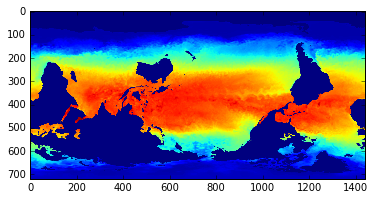

In [22]:
plt.imshow(lighter_array)

At this point, there is a slight complication in dealing with the array data. Now we are working with the array directly, and living outside of the comfort of the Xray objects, we note that these data are not arranged as a typical EPSG:4326 dataset; they are flipped and also broken on the 0.0 meridian. We will need to flip the data, split the array in half, and recombine it to create a classical EPSG:4326 structure. Numpy to the rescue...

In [23]:
rows, columns = lighter_array.shape              # get sizes
flipped_array = np.flip(lighter_array, axis=0)   # Reverse the array
left_side = flipped_array[:,int(columns/2):]     # split the array... 
right_side = flipped_array[:,:int(columns/2)]    # ...into two halves. Then recombine.
wsg84_array = np.concatenate((flipped_array[:,int(columns/2):],flipped_array[:,:int(columns/2)]), axis=1)
print(wsg84_array.shape)                         #  confirm we havent screwed the size of the array
#plt.imshow(wsg84_array)

(720, 1440)


Finally, the array is now ordered in an ESPG:4326 structure, and maintains its original, high-spatial resolution.

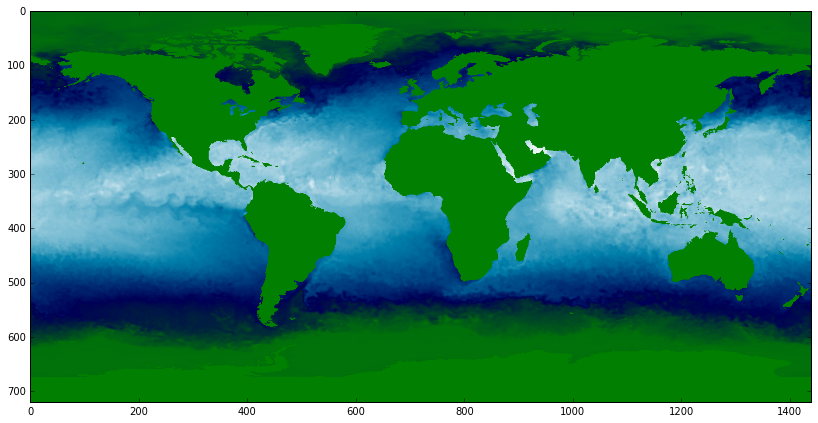

In [24]:
plt.figure(figsize=(14,10))
plt.imshow(wsg84_array, cmap=cm.ocean)

**Note**: To re-associate the 0-255 values with the original array values, you will need to create a list of categorisation bins. We reccomend creating the bin:value mapping at this stage. Usually, we pass this mapping with the lightweight data, e.g. via cartocss.
You simply need to invert the previous operation. 

E.g. the below shows how we could find the relationship between several steps in the range of 1-255, and their associated SST values, and then create a dictionary object from these data for later use in plotting.

In [85]:
light_range = np.array(range(1,250, 20))

physical_values = convert_array(light_range, oldMin=1, oldMax=255, missing_value=0,
              newMin=sst.valid_min, newMax=sst.valid_max, newMissing=-999)

d_lookup =dict(zip(light_range, physical_values))    
print(d_lookup)

{1: -3, 21: 0, 41: 4, 61: 8, 81: 12, 101: 15, 121: 19, 141: 23, 161: 27, 181: 31, 201: 34, 221: 38, 241: 42}


### Save data array in compressed GeoTIFF

Now we have the data converted to 0-255 values, and restructured to match an ESPG:4326 grid, we need to save the data as a GEOTIFF. We can do this using RASTERIO. Saving these data in the geotiff format will require us to create a dictionary of values.

One of which is the **transform**. Rasterio has some methods to help us set this, but it will essentially create an Affine transformation [info](http://www.perrygeo.com/python-affine-transforms.html), {'transform': (a,b,c,d,e,f)}

* a = width of a pixel
* b = row rotation (typically zero)
* c = x-coordinate of the upper-left corner of the upper-left pixel
* d = column rotation (typically zero)
* e = height of a pixel (typically negative)
* f = y-coordinate of the of the upper-left corner of the upper-left pixel

We can use the rasterio.transform.from_origin() method to create the transform in this case, as we have an unrotated grid, this only requires us to set an upper west and north pixel, and set the pixel xsize and ysize. **Note, that the west and north values must be from the centre of the pixel, not the edges.**

notes: [Example](https://cgcooke.github.io/GDAL/) of someone doing a similar operation

In [26]:
pixel_size = 0.25
west = -179.875 - pixel_size
north = 89.875 - pixel_size

trans = rasterio.transform.from_origin(west, north, 0.25, 0.25)
trans

Affine(0.25, 0.0, -180.125,
       0.0, -0.25, 89.625)

We have hardcoded the values here to be clear, but usually the pixel lat/lon can be found/accessed from the netcdf metdatada directly, as shown below, and from this, the transform coordinates worked-out.

Note, in the from_origin() method, west should be a value from -180 to 180 (not 0-360).

In [27]:
print(ncexample.attrs['geospatial_lat_min'])
print(ncexample.attrs['geospatial_lon_max'])

-89.875
359.875


In [28]:
# # Setting the AFFINE transformation (if it cannot be directly read from the netcdf)
# # (see following section for more on this last point)

# pixel_height = 180/720 * -1.
# pixel_width = 360/1440
# upper_left_x_coordinate = ncexample.attrs['Westernmost_Easting'] # i.e. Westernmost Easting
# upper_left_y_coordinate = ncexample.attrs['Northernmost_Northing'] # Norternmost northing

# affine = rasterio.Affine(pixel_width, 0, upper_left_x_coordinate, 0, pixel_height, upper_left_y_coordinate)
# affine

In [29]:
# rasterio.transform.from_bounds(west, south, east, north, width, height)
# Docstring:
# Return an Affine transformation given bounds, width and height.

# Return an Affine transformation for a georeferenced raster given
# its bounds `west`, `south`, `east`, `north` and its `width` and
# `height` in number of pixels.

In the profile dictionary, which essentially contains the information for rasterio to construct a geotiff, we have included a data type, compression type, and set the nodata value. All of these settings are important for us, as we have specifically set the data values to fit within an int8 representation system, and cast missing values as 0. Without these settings the file will be larger than it needs to be.

In [30]:
profile = {'driver': 'GTiff', 
           'dtype': 'uint8',
           'compress': 'lzw',
           'nodata': 0,
           'width': 1440,
           'height': 720,
           'count': 1,
           'crs':'EPSG:4326',
           'transform': trans,
           'tiled': False}

In [31]:
with rasterio.open('testout.tif', 'w', **profile) as dst:
    dst.write(wsg84_array.astype(profile['dtype']), 1)

In [32]:
!ls -lrth testout.tif

-rw-r--r--  1 Ben  staff   278K 30 Mar 09:28 testout.tif


Finally, we can see that the above process results in the creation of a <300kb geotiff from the 7mb source, i.e. a **95% reduction in file size**.

### Rasterio and NetCDF

Rasterio can also directly read NetCDF files. In this case, the profile can be extracted from the netcdf metadata automatically. Then, after manipulating the data array, the dictionary keys could simply be updated/amended as needed.

In [33]:
# Rasterio can also directly read a netcdf file also, including via OpenDAP

input_file = "./data/modis_example.nc"

with rasterio.open(input_file) as src:
#     #print(src)
#     #metadata = src.meta
     profile = src.profile
     image_array = src.read()
#profile

In [34]:
# The array has the format of band, lat, lon
image_array.shape

(1, 180, 360)

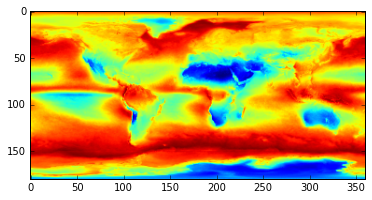

In [35]:
plt.imshow(image_array[0]) # preview plot the first (and only) band

In [36]:
profile # examine the profile info extracted from the netcdf data

{'driver': 'netCDF', 'dtype': 'float32', 'nodata': -9999.0, 'width': 360, 'height': 180, 'count': 1, 'crs': CRS({}), 'transform': Affine(1.0, 0.0, -180.0,
       0.0, -1.0, 90.0), 'tiled': False}

### Rasterio and geotiff

Open a connection to a three-band (RGB) geotiff image, and extract the info.

In [37]:
with rasterio.open('./data/RGB.byte.tif') as src:
    profile = src.profile
    transform = src.transform
    r, g, b = src.read()

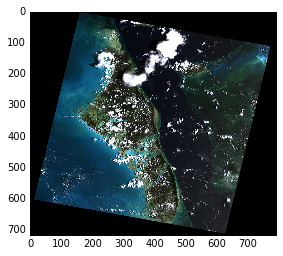

In [38]:
# Preview data with Matplotlib 
img = mpimg.imread('./data/RGB.byte.tif')
plt.imshow(img)

In [39]:
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 791, 'height': 718, 'count': 3, 'crs': CRS({'init': 'epsg:32618'}), 'transform': Affine(300.0379266750948, 0.0, 101985.0,
       0.0, -300.041782729805, 2826915.0), 'tiled': False, 'interleave': 'pixel'}

### Windowing large data

Sometimes we will be passed large raster files, and want to run preview/sample analses on these data. Other times, we may wish to break-down the analysis of large files into smaller chunks. In this case, we will use a chunking (or windowing) approach to access these data.

For example, the [EuroLST BioCLIM data](http://www.geodati.fmach.it/eurolst.html) are in TIFF format, and ~1GB each. You can download one from the previous link, uncompress the raster, and then access chunks/windows via the following code snippet.

In [42]:
from rasterio.plot import show_hist
from rasterio.plot import show

In [123]:
# Note, intend to create a slider widget here, and allow users to change window in X and Y start, and lenght (size)
# currently there seems to be a bug in the widgets that is stopping me from including this at the moment.
# so will leave this feature unfinished for now.

input_data_source = '/Users/Ben/Downloads/eurolst_clim/eurolst_clim.bio01.tif' # <-- point to your big raster
with rasterio.open(input_data_source) as inData:
    profile = inData.profile

pix_height = profile['height']  # use the profile metadata to get info like the pixel dimensions,
pix_width = profile['width']    # which is how you will know to set the window sizes.

#window = (6000, 12000), (6000, 12000) # large window (start X, end X) (start Y, end Y)
window = (8000,9000),(8000,9000)       # smaller window

def windowed_view(window):
    with rasterio.open(input_data_source, blockxsize=256, blockysize=256) as inData:
        profile = inData.profile
        dslice = inData.read(1, window=window, masked=True)
        plt.imshow(dslice,cmap=cm.gist_ncar)
        plt.show()
        val_range = dslice.max() - dslice.min()
        show_hist(dslice, bins = val_range, normed=True, histtype='stepfilled')

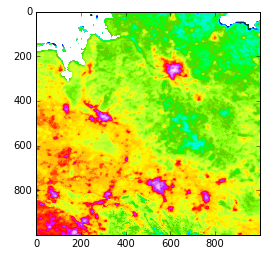

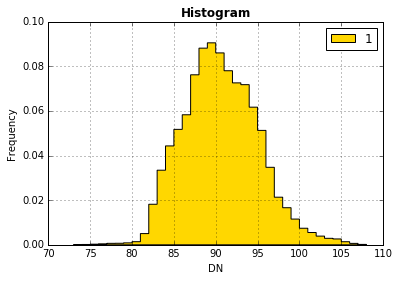

In [124]:
windowed_view(window=window)

### Downloading Google's Earth Engine Images

We commonly work with Google's [Earth Engine](https://earthengine.google.com), and may wish to simply extract an Image resource from this platform. The below snippet demonstrates how to download an image, and convert it to a geotiff, ready to be used as a web-map.

To use Earth Engine, you will need an account. You will then need to authenticate your session, as detailed [here](https://developers.google.com/earth-engine/python_install).

In [134]:
from urllib.request import urlopen
import zipfile
import ee
ee.Initialize()

In [132]:
bbox = (69.5, 28.25, 70.1, 28.65)
scale = 250
image_name = 'srtm90_v4'              # <-- This is the name of the image resource in the E.E. catalouge
bands =['elevation']                  # This is the band of the image we wish to access
download_zip = '.testing.zip'  # This is a temporary file we will download the data to

If so desired, you could download only a region or geometrical subset of the Image. We demonstrate how to do this via the bbox setting above, and the region key in the dictionary below. Passing the an ee.Geometry object, such as a bounding box, as we show here, would cause the downloaded image to be within that location only.

In [133]:
image = ee.Image(image_name)

ee_dic = {}

url = image.getDownloadUrl({'min':0,      # 
                            'max':3000,
                            'scale': 10000,  # scale in meters 
                            'crs': 'EPSG:4326',
                            #'region': ee.Geometry.Rectangle(bbox).toGeoJSONString()
                           })

print('Downloading image...')
print("url: ", url)
data = urlopen(url)
with open(download_zip, 'wb') as fp:
    while True:
        chunk = data.read(16 * 1024)
        if not chunk: break
        fp.write(chunk)
print('Download complete!')

url:  https://earthengine.googleapis.com//api/download?docid=f6041fac8324f694c8151cb3b29a655c&token=706d2dea13693fb5729830c675beac9f
Download complete!


In [143]:
# extract the zip file transformation data
z = zipfile.ZipFile(download_zip, 'r')
target_folder_name = download_zip.split('.zip')[0]
z.extractall(target_folder_name)

# Load tiff file data
with rasterio.open('.testing/srtm90_v4.elevation.tif') as src:
    data = src.read()
    profile = src.profile
    transform = src.transform

In [159]:
ls -lrth .testing/

total 20952
-rw-r--r--  1 Ben  staff    10M 30 Mar 10:26 srtm90_v4.elevation.tif
-rw-r--r--  1 Ben  staff   108B 30 Mar 10:26 srtm90_v4.elevation.tfw


Profile {'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 4008, 'height': 1336, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.08983152841195215, 0.0, -180.0223829375521,
       0.0, -0.08983152841195215, 60.00746097918403), 'tiled': False}
Dimensions (1, 1336, 4008)


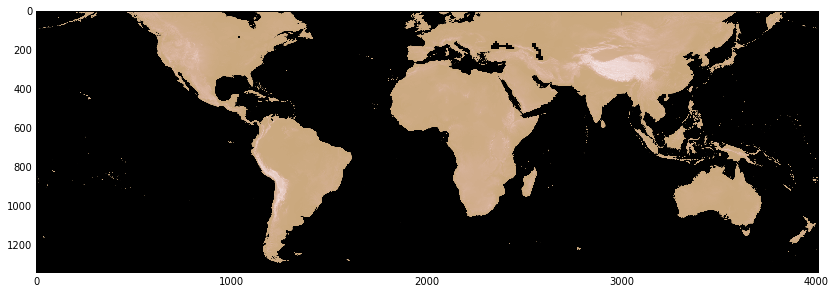

In [161]:
print("Profile", src.profile)
print("Dimensions", data.shape)

plt.figure(figsize=(14,10))
plt.imshow(data[0], interpolation=None, cmap=cm.gist_earth)
plt.show()